## Для gosu.ai

In [321]:
from collections import defaultdict, Counter
import json
import time
import requests
from scipy.stats import shapiro
from scipy.stats import ttest_ind
import statsmodels.api as sm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="muted")
%matplotlib inline

### problem 1

Основная идея: делаем, как сказано. Считаем построчно, для каждого события увеличиваем счётчик.

In [206]:
event_types_counter = Counter()

with open('data/test-task/3549145408_1618162017.jsonl') as f:
    for line in f:
        event_types_counter[(json.loads(line)['type'])] += 1

Посмотрим на самые популярные события

In [380]:
event_types_counter.most_common(5)

[('cursor', 550909),
 ('camera', 550909),
 ('actions', 85322),
 ('interval', 68050),
 ('DOTA_COMBATLOG_DAMAGE', 30699)]

Сохраним результаты в файл:

In [461]:
with open('data/test-task/output/types.json', 'w') as f:
    json.dump(event_types_counter, f)

### problem 2

Создадим словарь, где для каждого игрока мы будем хранить список координат x его курсора, и список координат y.

In [208]:
cursors_states = defaultdict(lambda : defaultdict(list))
player_slots = set(list(range(10)))

with open('data/test-task/3549145408_1618162017.jsonl') as f:
    for line in f:
        event = json.loads(line)
        if event['type'] == 'cursor' and event['slot'] in player_slots:
            # position = (event['x'], event['y'])
            # cursors_states[event['slot']].append(position)
            cursors_states[event['slot']]['x'].append(event['x'])
            cursors_states[event['slot']]['y'].append(event['y'])

Переведем данные в np.array для удобства

In [209]:
for slot in range(10):
    cursors_states[slot]['x'] = np.array(cursors_states[slot]['x'])
    cursors_states[slot]['y'] = np.array(cursors_states[slot]['y'])

Я так понял, отсчет координат ведется от левого верхнего угла, так как логично ожидать подсветки в районе карты. Поэтому отразим координаты по оси Y и сохраним графики.

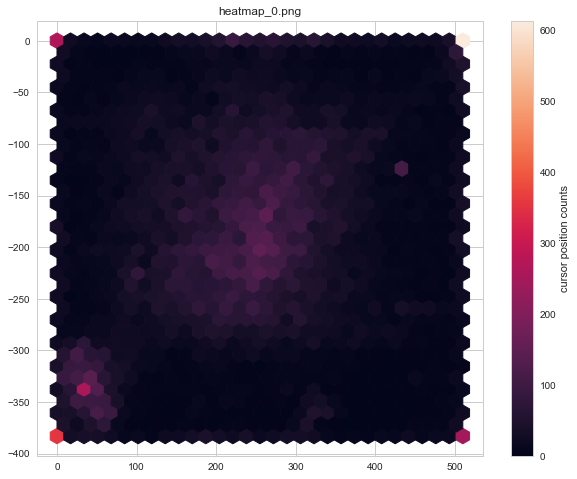

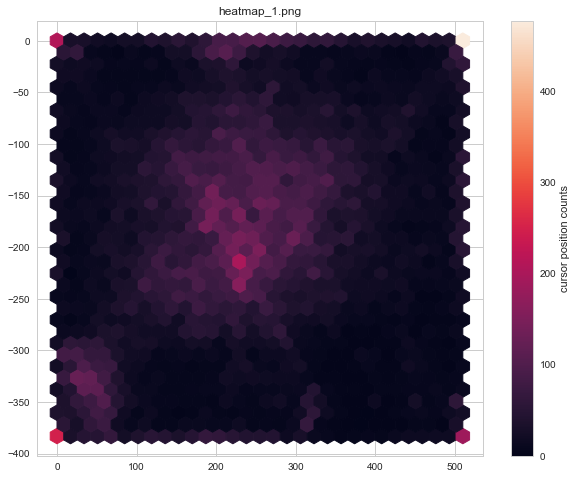

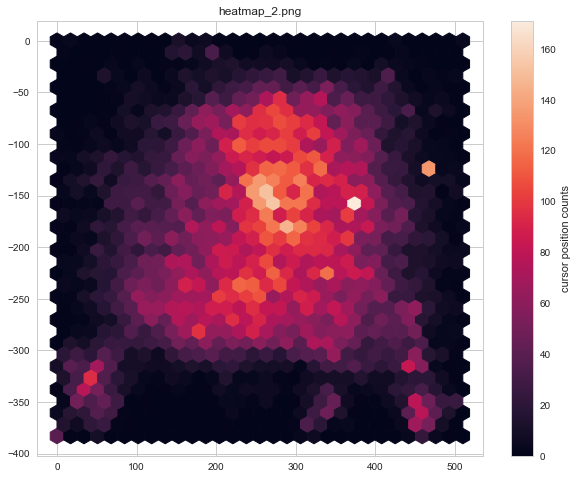

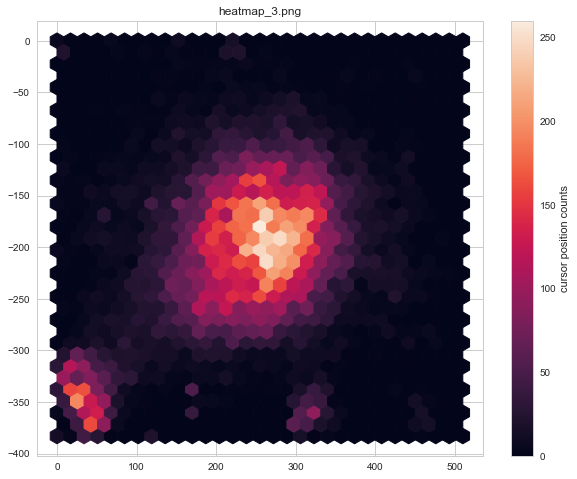

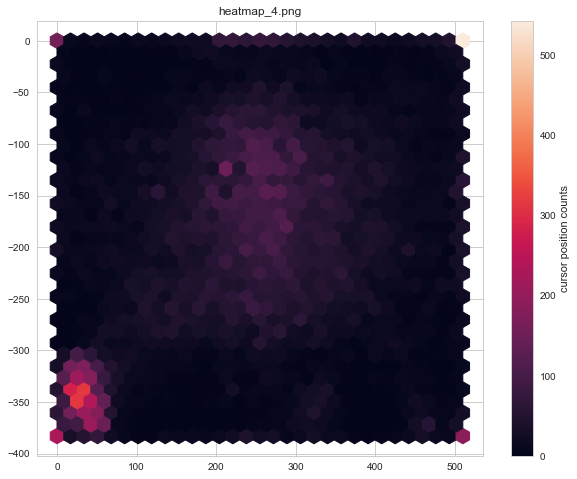

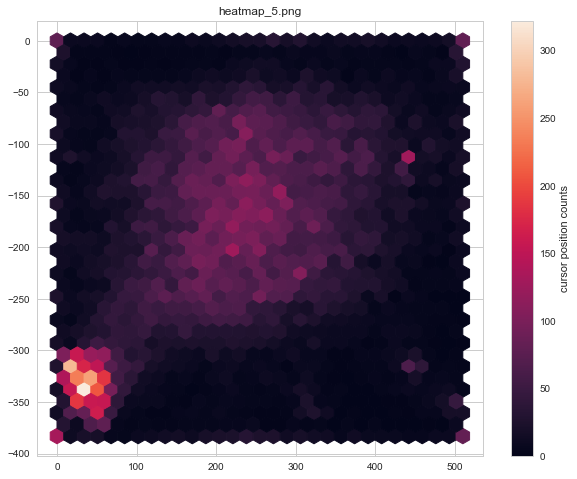

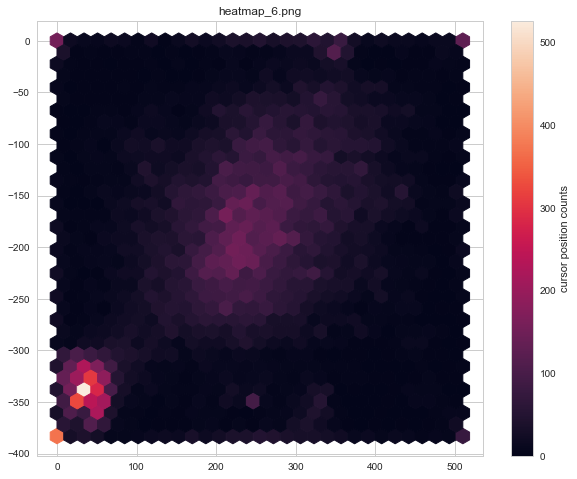

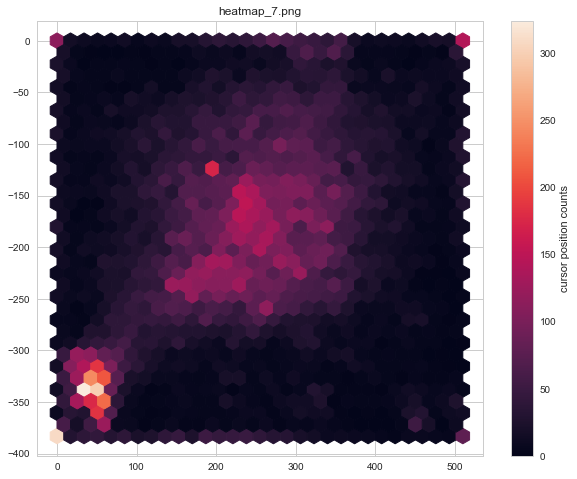

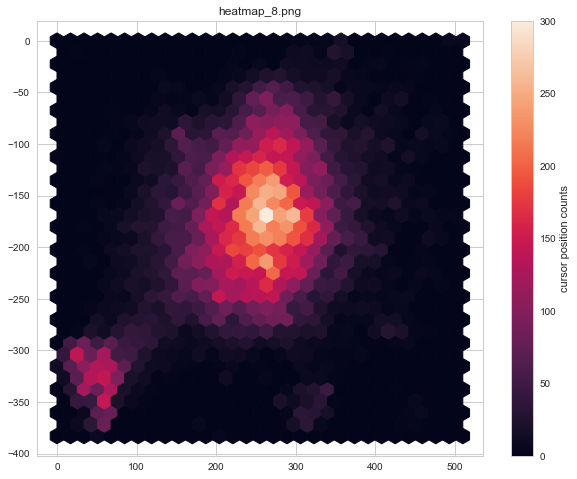

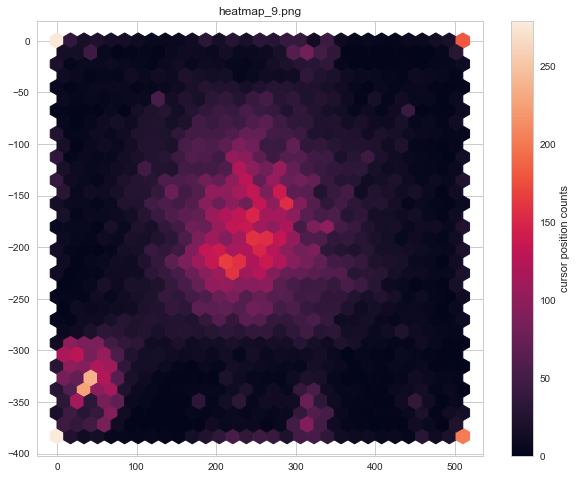

In [242]:
for i in range(10):
    plt.figure(figsize=(10,8))
    plt.title('heatmap_{}.png'.format(i))
    plt.hexbin(cursors_states[i]['x'], -cursors_states[i]['y'], gridsize=30)
    cb = plt.colorbar()
    cb.set_label('cursor position counts')
    plt.savefig('data/test-task/output/heatmap_{}.png'.format(i))

### problem 3

Будем пользоваться api, что находится по этому адресу:

In [243]:
route = 'https://api.opendota.com/api/explorer'

Зададим два SQL-запроса, один - для патча 7.06, другой, для патча 7.07. Я так понимаю, что за "профессиональность" матча отвечает параметр leagues.tier = 'professional'

In [255]:
sql_query1 = '''SELECT
    player_matches.purchase_log
    FROM matches
    JOIN match_patch using(match_id)
    JOIN player_matches using(match_id)
    JOIN leagues using(leagueid)
    WHERE match_patch.patch = '7.06'
    AND player_matches.hero_id = 1
    AND leagues.tier = 'professional'
    ORDER BY matches.start_time DESC NULLS LAST
LIMIT 1000'''


sql_query2 = '''SELECT
    player_matches.purchase_log
    FROM matches
    JOIN match_patch using(match_id)
    JOIN player_matches using(match_id)
    JOIN leagues using(leagueid)
    WHERE match_patch.patch = '7.07'
    AND player_matches.hero_id = 1
    AND leagues.tier = 'professional'
    ORDER BY matches.start_time DESC NULLS LAST
LIMIT 1000'''

Совершим запросы и убедимся, что они удачно прошли.

In [256]:
r1 = requests.get(route, params= {'sql':sql_query1})
print(r1.status_code)

200


In [257]:
r2 = requests.get(route, params= {'sql':sql_query2})
print(r2.status_code)

200


In [260]:
def get_bf_time(req):
    bf_times = []
    err_count = 0
    for row in req.json()['rows']:
        try:
            for el in row['purchase_log']:
                if el['key'] == 'bfury':
                    bf_times.append(el['time'])
        except:
            err_count += 1
            print(row)
    print("err count: {}".format(err_count))
    return np.array(bf_times)

In [262]:
old_bf_distribution = get_bf_time(r1)
new_bf_distribution = get_bf_time(r2)

{'purchase_log': None}
err count: 1
{'purchase_log': None}
err count: 1


In [266]:
print(len(old_bf_distribution))
print(len(new_bf_distribution))

190
79


In [284]:
print(np.mean(old_bf_distribution), np.std(old_bf_distribution))
print(np.mean(new_bf_distribution), np.std(new_bf_distribution))

976.3947368421053 122.96129889087358
871.3291139240506 127.45669123165405


Посмотрим на распределения

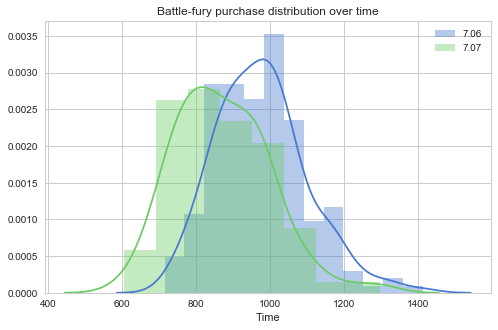

In [283]:
plt.figure(figsize=(8,5))
plt.title('Battle-fury purchase distribution over time')
plt.xlabel('Time')
sns.distplot(old_bf_distribution)
sns.distplot(new_bf_distribution)
plt.legend(['7.06','7.07'])

Проверим с попощью теста Шапиро-Вилка распределения на нормальность.

In [277]:
print(shapiro(old_bf_distribution))
print(shapiro(new_bf_distribution))

(0.9782540798187256, 0.004682811442762613)
(0.9732933640480042, 0.09605810791254044)


In [104]:
ttest_ind(old_bf_distribution, new_bf_distribution)

Ttest_indResult(statistic=6.290554095542093, pvalue=1.2879814650839935e-09)

Для патча 7.07 достигаемый уровень значимости проверки гипотезы о нормальном распределении: 0.09. Если нас это не пугает, то можем применить двувыборочный т-критерий Стьюдента о равенстве средних, который в итоге говорит нам о том, что гипотезу о равенстве средних следует откинуть.

По-хорошему, наверное, тут лучше пуассоновским распределением моделировать покупку, потому что левый хвост должен быть не таким растянутым. И тесты соответсвующие провести. Ну или непараметрическими методами воспользоваться типа бутстрепа.

Проверим бутстрепом на всякий случай

In [299]:
b1, b2 = [], []

for b in range(1000):
    b1.append(np.mean(np.random.choice(old_bf_distribution, size=30)))
    b2.append(np.mean(np.random.choice(new_bf_distribution, size=30)))
    
b1 = np.array(b1)
b2 = np.array(b2)

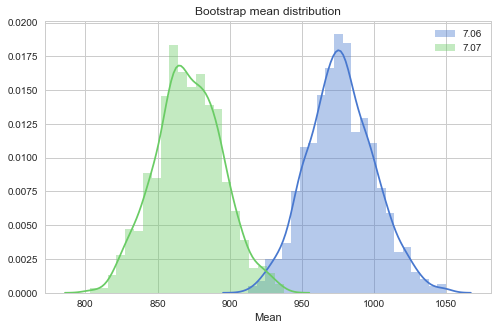

In [304]:
plt.figure(figsize=(8,5))
plt.title('Bootstrap mean distribution')
plt.xlabel('Mean')
sns.distplot(b1)
sns.distplot(b2)
plt.legend(['7.06','7.07'])

Доверительный интервалы нарисуем

In [305]:
k = 2
print(np.mean(b1) - k*np.std(b1), np.mean(b1) + k*np.std(b1))
print(np.mean(b2) - k*np.std(b2), np.mean(b2) + k*np.std(b2))

930.893618562141 1022.9680481045257
825.3824709539728 917.2933290460272


Бутстреп говорит, что с 5%-уровнем значимости можем отвергнуть гипотезу о равенстве средних. Но с 1% уже не можем отвергнуть.

### problem 4

Для данного матча сохраним для каждого момента времени стоимость каждого персонажа и построим модель линейной регрессии.

In [320]:
times = []
golds = []

with open('data/test-task/3549145408_1618162017.jsonl') as f:
    for line in f:
        line_dict =  json.loads(line)
        if line_dict['type'] == 'interval':
            golds.append(line_dict['gold'])
            times.append(line_dict['time'])

times = np.array(times)
golds = np.array(golds)

print(len(times), len(golds))

68050 68050


In [361]:
X = times.reshape(-1,1)
y = golds

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()

In [362]:
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                 1.713e+05
Date:                Mon, 09 Apr 2018   Prob (F-statistic):               0.00
Time:                        09:10:32   Log-Likelihood:            -6.5457e+05
No. Observations:               68050   AIC:                         1.309e+06
Df Residuals:                   68048   BIC:                         1.309e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3867.9249     28.021   -138.037      0.0

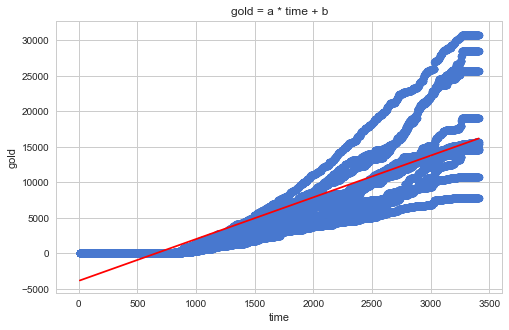

In [363]:
plt.figure(figsize=(8,5))
plt.title('gold = a * time + b')

plt.xlabel('time')
plt.ylabel('gold')
plt.plot(times, times * 5.8809 - 3867.9249, c='r')
plt.scatter(times, golds)

Из значения F-статистики видим, что коэффициенты значимы.

Первые 10 минут матча стоимость всех персонажей нулевая и не меняется. Уровень персонажей в это время тоже нулевой. Я так понял, что это предматчевое время в лобби. Так что для модели необходимо использовать intercept.

Коэффициент наклона характеризует увеличение средней стоимости персонажей в каждую секунду матча.

### problem 5

В этой задаче сложность заключается в определении начала атаки. Понятно, что мы не можем считать началом атаки момент, когда герой в первый раз получает урон: ведь от момента первого урона от, скажем, крипа, до непосредственно смерти героя могут пройти десятки минут.

Под атакой, наверное, разумно понимать высокую концентрацию урона на момент времени. Чтобы выделить летальные атаки, я предлагаю смотреть на то, сколько герой получил урона за последние, скажем, 20 ударов по нему. Во время атак, в том числе летальных, куммулятивный урон, нанесенный персонажу, должен заметно расти, и таким образом начало активного роста куммулятивного урона можно считать за начало атаки.

Понятно, что такой подход не позволит обнаружить ситуации, когда, например, персонаж стоял на линии с малым количеством HP и умер от одного внезапного удара из леса, но с другой стороны, такие случаи наверное не очень типичны в контексте обсуждения именно гангов.

In [417]:
from collections import deque

cum_damage_story = defaultdict(list)
cur_cum_damage = Counter()
dam_story = defaultdict(lambda : deque([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]))
death_counter = Counter()

with open('data/test-task/3549145408_1618162017.jsonl') as f:
    for line in f:
        line_dict =  json.loads(line)
        if line_dict['type'] == 'DOTA_COMBATLOG_DAMAGE' and 'hero' in line_dict['targetname']:
            if cur_cum_damage[line_dict['targetname']] == 0:
                dam_story[line_dict['targetname']] = deque([0,0,0,0,0,0,0,0,0,0])
            dam = line_dict['value']
            cur_cum_damage[line_dict['targetname']] -= dam_story[line_dict['targetname']].popleft()
            cur_cum_damage[line_dict['targetname']] += dam
            cum_damage_story[line_dict['targetname']].append(cur_cum_damage[line_dict['targetname']])
            dam_story[line_dict['targetname']].append(dam)
        elif line_dict['type'] == 'DOTA_COMBATLOG_DEATH' and 'hero' in line_dict['targetname']:
            cur_cum_damage[line_dict['targetname']] == 0
            cum_damage_story[line_dict['targetname']] += [0]*20
            death_counter[line_dict['targetname']] += 1

Убедимся на графике ниже, что моментам смерти (значения в нуле) предшествуют быстро растущие сегменты графика. Началом атаки надо считать локальный минимум перед взрывным ростом, ведущим к смерти.

hero: npc_dota_hero_silencer
num of deaths: 9


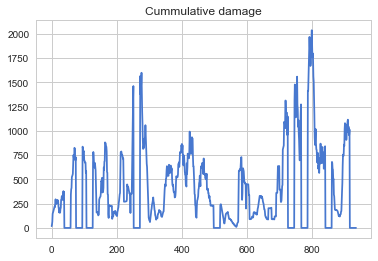

In [422]:
i = 2
print('hero: {}'.format(list(cum_damage_story.keys())[i]))
print('num of deaths: {}'.format(death_counter[list(cum_damage_story.keys())[i]]))

plt.title('Cummulative damage')
plt.plot(cum_damage_story[list(cum_damage_story.keys())[i]])

К сожалению, не успел аккуратно этот подход дореализовать, поэтому вам высылаю вам самое базовое и неадекватное решение: где началом атаки считается время первого урона, полученного героем.

In [443]:
class the_kill(object):
    def __init__(self, target_hero, start_time):
        self.target_hero = target_hero
        self.start_time = start_time
        self.end_time = None
        self.kill_participants = []
        
    def append_participant(self, hero):
        self.kill_participants.append(hero)
        
    def set_end_time(self, end_time):
        self.end_time = end_time
        
    def __str__(self):
        answer = {'target hero' : self.target_hero,
                  'kill_participants' : list(set(self.kill_participants)),
                  'start_time' : self.start_time,
                  'end_time' : self.end_time}
        return answer.__str__()
    
    def __dict__(self):
        answer = {'target hero' : self.target_hero,
                  'kill_participants' : list(set(self.kill_participants)),
                  'start_time' : self.start_time,
                  'end_time' : self.end_time}
        return answer

In [444]:
kills = []
kill_counter = Counter()
kill_proccesser = dict()

with open('data/test-task/3549145408_1618162017.jsonl') as f:
    for line in f:
        line_dict =  json.loads(line)
        if line_dict['type'] == 'DOTA_COMBATLOG_DAMAGE':
            if kill_counter[line_dict['targetname']] == 0:
                kill_counter[line_dict['targetname']] += 1
                kill_proccesser[line_dict['targetname']] = the_kill(line_dict['targetname'], line_dict['time'])
            kill_proccesser[line_dict['targetname']].append_participant(line_dict['attackername'])
        elif line_dict['type'] == 'DOTA_COMBATLOG_DEATH' and 'hero' in line_dict['targetname']:
            kill_counter[line_dict['targetname']] = 0
            kill_proccesser[line_dict['targetname']].set_end_time(line_dict['time'])
            kills.append(kill_proccesser[line_dict['targetname']])
            kill_proccesser[line_dict['targetname']] = None

In [440]:
print(kills[1])

{'target hero': 'npc_dota_hero_silencer', 'kill_participants': ['npc_dota_hero_earth_spirit', 'npc_dota_hero_tinker', 'npc_dota_creep_goodguys_melee'], 'start_time': 906.13367, 'end_time': 959.7206}


Неадекватность видна, если посмотреть на распределение времени атак: существуют атаки, которые заняли полчаса.

(array([23., 16.,  7.,  1.,  3.,  0.,  0.,  0.,  1.,  1.]),
 array([1.39970000e+00, 2.21905345e+02, 4.42410990e+02, 6.62916635e+02,
        8.83422280e+02, 1.10392792e+03, 1.32443357e+03, 1.54493922e+03,
        1.76544486e+03, 1.98595051e+03, 2.20645615e+03]),
 <a list of 10 Patch objects>)

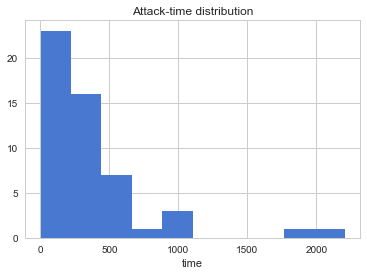

In [446]:
deltas = []
for kill in kills:
    delta = kill.end_time - kill.start_time
    deltas.append(delta)
    
plt.title('Attack-time distribution')
plt.xlabel('time')
plt.hist(deltas)

In [460]:
with open('data/test-task/output/kills.json', 'a') as f:
    for kill in kills:
        json.dump(kill.__dict__(), f)
        f.write('\n')